Generating graph...
Graph generated.

--- Initial Setup ---
Hospitals:
Location (Node): 152383705, Capacity: 36
Location (Node): 2496153589, Capacity: 26
Location (Node): 152844875, Capacity: 34

Victims:
Location (Node): 152895712, Rating: G, Visited: False
Location (Node): 152309872, Rating: U, Visited: False
Location (Node): 152177111, Rating: G, Visited: False
Location (Node): 152350278, Rating: U, Visited: False
Location (Node): 152541978, Rating: U, Visited: False
Location (Node): 153155904, Rating: U, Visited: False
Location (Node): 152805610, Rating: R, Visited: False
Location (Node): 1339150279, Rating: G, Visited: False
Location (Node): 4322352079, Rating: R, Visited: False
Location (Node): 152405710, Rating: U, Visited: False
Location (Node): 2355593678, Rating: U, Visited: False
Location (Node): 152792025, Rating: G, Visited: False
Location (Node): 152172707, Rating: U, Visited: False
Location (Node): 3475118247, Rating: U, Visited: False
Location (Node): 152287818, Rating:

/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_86529/3075830870.py:526: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', len(routes))
/opt/anaconda3/lib/python3.11/site-packages/osmnx/plot.py:334: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")
/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_86529/3075830870.py:540: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which 

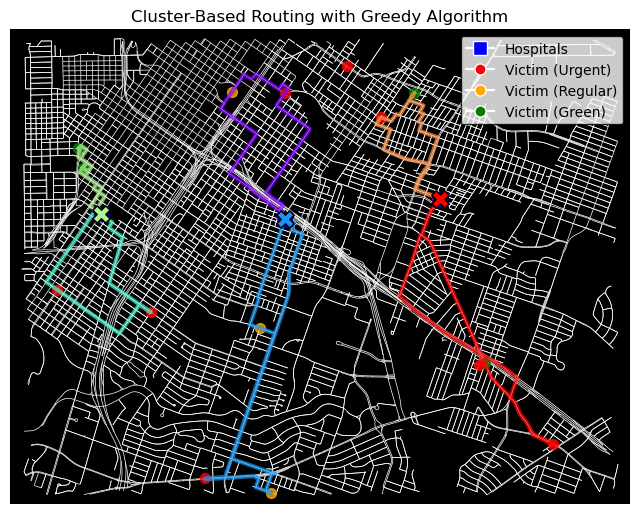

Plotting complete.


In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration Parameters ---
BBOX = (29.76, 29.7, -95.3, -95.39)

# Number of entities to generate
NUM_HOSPITALS = 3
NUM_VICTIMS = 15
NUM_AMBULANCES_PER_HOSPITAL = 1
NUM_RESCUE_TRUCKS_PER_HOSPITAL = 1

# Parameters for route scoring
# Score = (travel_time / TRAVEL_TIME_WEIGHT_FACTOR) + (risk / RISK_WEIGHT_FACTOR)
TRAVEL_TIME_WEIGHT_FACTOR = 60 # Divides travel time to normalize its contribution
RISK_WEIGHT_FACTOR = 3        # Divides risk to normalize its contribution

# --- Helper Classes ---

class Hospital:
    """
    Represents a hospital with a unique node ID from the graph and a capacity.
    """
    def __init__(self, node_id, capacity):
        self.node_id = node_id
        self.capacity = capacity

    def __repr__(self):
        return f"Location (Node): {self.node_id}, Capacity: {self.capacity}"

class Victim:
    """
    Represents a victim with a unique node ID from the graph, a rating (e.g., urgency),
    and a boolean indicating if they have been visited.
    """
    def __init__(self, node_id, rating):
        self.node_id = node_id
        self.rating = rating  # e.g., 'U' (Urgent), 'R' (Regular), 'G' (Green)
        self.visited = False

    def __repr__(self):
        return f"Location (Node): {self.node_id}, Rating: {self.rating}, Visited: {self.visited}"

class Vehicle:
    """
    Represents a vehicle with its type, starting node, maximum risk tolerance,
    capacity, and current state (amount of victims, route, total time/risk).
    """
    def __init__(self, vehicle_type, start_node_id, max_risk, capacity):
        self.vehicle_type = vehicle_type
        self.current_node = start_node_id # Current location of the vehicle
        self.max_risk = max_risk          # Maximum accumulated risk vehicle can handle
        self.capacity = capacity          # Maximum number of victims vehicle can carry
        self.current_amount = 0           # Current number of victims on board
        self.route = [start_node_id]      # List of nodes forming the vehicle's path
        self.total_time = 0               # Accumulated travel time
        self.total_risk = 0               # Accumulated risk
        self.victims_served = []          # List of Victim objects served by this vehicle

    def __repr__(self):
        return (f"Type: {self.vehicle_type}, Location (Node): {self.current_node}, "
                f"Max Risk: {self.max_risk}, Capacity: {self.capacity}, "
                f"Current Amount: {self.current_amount}")

class RouteInfo:
    """
    Stores detailed information about a calculated route between two nodes,
    including time, risk, the path itself, and a combined score.
    """
    def __init__(self, start_node, end_node, time, risk, path, score):
        self.start_node = start_node
        self.end_node = end_node
        self.time = time
        self.risk = risk
        self.path = path
        self.score = score # Combined metric of time and risk for decision making

    def __repr__(self):
        return (f"From Node {self.start_node} to Node {self.end_node}: \n"
                f"  Score: {self.score:.2f}\n"
                f"  Time: {self.time:.2f} seconds\n"
                f"  Risk: {self.risk:.2f}\n"
                f"  Path: {self.path}")

# --- Graph and Entity Generation Functions ---

def generate_graph(bbox_coords):
    """
    Generates a street network graph from a bounding box using OSMnx.
    Adds edge speeds and travel times to the graph.

    Args:
        bbox_coords (tuple): A tuple (north, south, east, west) defining the
                             geographical bounding box.

    Returns:
        networkx.MultiDiGraph: The generated street network graph.
    """
    print("Generating graph...")
    # Use the bbox parameter directly as recommended by OSMnx
    G = ox.graph_from_bbox(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3], network_type='drive')
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)
    print("Graph generated.")
    return G

def get_random_node(G):
    """
    Returns a random node ID from the graph's nodes.
    """
    return random.choice(list(G.nodes()))

def create_hospitals(G, num_hospitals):
    """
    Creates a list of Hospital objects, each located at a random node in the graph
    and assigned a random capacity.

    Args:
        G (networkx.MultiDiGraph): The graph.
        num_hospitals (int): The desired number of hospitals.

    Returns:
        list: A list of Hospital objects.
    """
    hospitals = []
    for _ in range(num_hospitals):
        node_id = get_random_node(G)
        capacity = random.randint(10, 50) # Random capacity for hospitals
        hospitals.append(Hospital(node_id, capacity))
    return hospitals

def create_victims(G, num_victims):
    """
    Creates a list of Victim objects, each located at a random node in the graph
    and assigned a random urgency rating.

    Args:
        G (networkx.MultiDiGraph): The graph.
        num_victims (int): The desired number of victims.

    Returns:
        list: A list of Victim objects.
    """
    victims = []
    ratings = ['U', 'R', 'G'] # Urgent, Regular, Green
    for _ in range(num_victims):
        node_id = get_random_node(G)
        rating = random.choice(ratings)
        victims.append(Victim(node_id, rating))
    return victims

def create_vehicles(hospitals, num_ambulances_per_hospital, num_rescue_trucks_per_hospital):
    """
    Creates a list of Vehicle objects, with each vehicle starting at a hospital location.
    Assigns different max risk and capacity based on vehicle type.

    Args:
        hospitals (list): List of Hospital objects where vehicles can start.
        num_ambulances_per_hospital (int): Number of ambulances to create per hospital.
        num_rescue_trucks_per_hospital (int): Number of rescue trucks to create per hospital.

    Returns:
        list: A list of Vehicle objects.
    """
    vehicles = []
    for hospital in hospitals:
        for _ in range(num_ambulances_per_hospital):
            vehicles.append(Vehicle('ambulance', hospital.node_id, max_risk=50, capacity=2)) # Increased max_risk
        for _ in range(num_rescue_trucks_per_hospital):
            vehicles.append(Vehicle('rescue_truck', hospital.node_id, max_risk=70, capacity=3)) # Increased max_risk
    return vehicles

# --- Route Calculation and Scoring ---

def calculate_risk(travel_time, vehicle_type):
    """
    Calculates a simplified risk value based on travel time and vehicle type.
    Risk increases with travel time; different vehicle types might have different
    inherent risk factors.

    Args:
        travel_time (float): The travel time in seconds.
        vehicle_type (str): The type of vehicle ('ambulance' or 'rescue_truck').

    Returns:
        float: The calculated risk value.
    """
    base_risk = travel_time / 10 # Example: 1 unit of risk per 10 seconds
    if vehicle_type == 'ambulance':
        return base_risk * 1.5 # Ambulances might face higher inherent risk due to urgency
    elif vehicle_type == 'rescue_truck':
        return base_risk * 1.2 # Rescue trucks might have slightly less risk
    return base_risk

def get_route_info(G, start_node, end_node, vehicle_type):
    """
    Calculates route information (time, risk, path, score) between two nodes
    in the graph. Uses NetworkX's shortest path algorithm.

    Args:
        G (networkx.MultiDiGraph): The street network graph.
        start_node (int): OSMID of the starting node.
        end_node (int): OSMID of the ending node.
        vehicle_type (str): Type of vehicle ('ambulance', 'rescue_truck') for risk calculation.

    Returns:
        RouteInfo or None: An object containing route details if a path exists,
                           or None if no path can be found.
    """
    if start_node == end_node:
        return RouteInfo(start_node, end_node, 0, 0, [start_node], 0) # Path should include the node itself

    try:
        # Calculate shortest path based on travel time
        path = nx.shortest_path(G, source=start_node, target=end_node, weight='travel_time')
        travel_time = nx.shortest_path_length(G, source=start_node, target=end_node, weight='travel_time')
        risk = calculate_risk(travel_time, vehicle_type)
        score = (travel_time / TRAVEL_TIME_WEIGHT_FACTOR) + (risk / RISK_WEIGHT_FACTOR)
        return RouteInfo(start_node, end_node, travel_time, risk, path, score)
    except nx.NetworkXNoPath:
        # No path exists between the start and end nodes
        return None
    except Exception as e:
        # Catch any other potential errors during path calculation
        print(f"Error calculating route from {start_node} to {end_node}: {e}")
        return None

# --- Clustering and Assignment ---

def euclidean_distance(node1, node2, G):
    """
    Calculates the Euclidean distance between two graph nodes based on their
    latitude and longitude coordinates.

    Args:
        node1 (int): OSMID of the first node.
        node2 (int): OSMID of the second node.
        G (networkx.MultiDiGraph): The graph, used to retrieve node coordinates.

    Returns:
        float: The Euclidean distance between the two nodes.
    """
    # Retrieve latitude (y) and longitude (x) from graph nodes
    lat1, lon1 = G.nodes[node1]['y'], G.nodes[node1]['x']
    lat2, lon2 = G.nodes[node2]['y'], G.nodes[node2]['x']
    return math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

def cluster_victims(G, victims, num_clusters):
    """
    Clusters victims into `num_clusters` groups using the K-Means algorithm
    based on their geographical coordinates. Finds the closest graph node
    to each cluster centroid.

    Args:
        G (networkx.MultiDiGraph): The graph.
        victims (list): List of Victim objects to be clustered.
        num_clusters (int): The desired number of clusters.

    Returns:
        tuple: A tuple containing:
            - dict: A dictionary mapping cluster_id to a list of Victim objects in that cluster.
            - dict: A dictionary mapping cluster_id to the OSMID of the graph node closest to its centroid.
    """
    if not victims:
        return {}, {}
    
    # Extract coordinates for clustering (latitude, longitude)
    coords = np.array([[G.nodes[v.node_id]['y'], G.nodes[v.node_id]['x']] for v in victims])

    # Ensure num_clusters does not exceed the number of victims
    n_clusters = min(num_clusters, len(victims))
    if n_clusters == 0:
        return {}, {} # No clusters if no victims or num_clusters is 0
    
    # Initialize KMeans with n_init to suppress warning and ensure robustness
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(coords)

    # Assign each victim to its determined cluster
    clusters = {i: [] for i in range(n_clusters)}
    for i, victim in enumerate(victims):
        cluster_id = kmeans.labels_[i]
        clusters[cluster_id].append(victim)

    # Find the graph node closest to each cluster centroid for routing purposes
    cluster_centroids_nodes = {}
    for cluster_id, centroid_coords in enumerate(kmeans.cluster_centers_):
        # ox.nearest_nodes takes (longitude, latitude)
        centroid_node = ox.nearest_nodes(G, centroid_coords[1], centroid_coords[0])
        cluster_centroids_nodes[cluster_id] = centroid_node
    
    return clusters, cluster_centroids_nodes

def assign_vehicles_to_clusters(G, vehicles, cluster_centroids):
    """
    Assigns vehicles to clusters using the Hungarian algorithm (optimal assignment)
    based on the Euclidean distance from each vehicle's starting hospital
    to the cluster centroid.

    Args:
        G (networkx.MultiDiGraph): The graph.
        vehicles (list): List of Vehicle objects.
        cluster_centroids (dict): Dictionary of {cluster_id: centroid_node_id}.

    Returns:
        dict: A dictionary mapping Vehicle objects to their assigned cluster_id.
    """
    if not vehicles or not cluster_centroids:
        return {}

    num_vehicles = len(vehicles)
    num_clusters = len(cluster_centroids)

    # Create cost matrix: cost[i][j] is the Euclidean distance from vehicle i's
    # starting hospital to cluster j's centroid.
    cost_matrix = np.zeros((num_vehicles, num_clusters))
    
    for i, vehicle in enumerate(vehicles):
        for j, cluster_id in enumerate(cluster_centroids.keys()):
            hospital_node = vehicle.route[0] # Vehicle's starting node (hospital)
            centroid_node = cluster_centroids[cluster_id]
            cost_matrix[i, j] = euclidean_distance(hospital_node, centroid_node, G)

    # Apply the Hungarian algorithm to find the optimal assignment
    # row_ind: indices of rows (vehicles)
    # col_ind: indices of columns (clusters) that they are assigned to
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    vehicle_assignments = {}
    assigned_clusters_tracker = set() # To track which clusters have been assigned

    # Populate initial assignments from Hungarian algorithm
    cluster_ids_list = list(cluster_centroids.keys())
    for i, j in zip(row_ind, col_ind):
        vehicle_assignments[vehicles[i]] = cluster_ids_list[j]
        assigned_clusters_tracker.add(cluster_ids_list[j])
    
    # Handle scenarios where num_vehicles != num_clusters
    # If there are more vehicles than clusters, assign remaining vehicles to the closest available cluster.
    # If all clusters are taken, assign to the closest overall.
    unassigned_vehicles = [v for v in vehicles if v not in vehicle_assignments]
    
    for vehicle in unassigned_vehicles:
        min_dist = float('inf')
        best_cluster_id = None
        
        # Prioritize unassigned clusters first
        available_unassigned_clusters = [cid for cid in cluster_ids_list if cid not in assigned_clusters_tracker]
        
        if available_unassigned_clusters:
            for cluster_id in available_unassigned_clusters:
                hospital_node = vehicle.route[0]
                centroid_node = cluster_centroids[cluster_id]
                dist = euclidean_distance(hospital_node, centroid_node, G)
                if dist < min_dist:
                    min_dist = dist
                    best_cluster_id = cluster_id
            if best_cluster_id is not None:
                vehicle_assignments[vehicle] = best_cluster_id
                assigned_clusters_tracker.add(best_cluster_id) # Mark as assigned
        else:
            # If all clusters are already assigned (e.g., more vehicles than clusters),
            # assign to the closest cluster overall. This implies multiple vehicles
            # might be assigned to the same cluster.
            for cluster_id in cluster_ids_list:
                hospital_node = vehicle.route[0]
                centroid_node = cluster_centroids[cluster_id]
                dist = euclidean_distance(hospital_node, centroid_node, G)
                if dist < min_dist:
                    min_dist = dist
                    best_cluster_id = cluster_id
            if best_cluster_id is not None:
                vehicle_assignments[vehicle] = best_cluster_id

    return vehicle_assignments

# --- Greedy Algorithm within Clusters ---

def greedy_routing_within_clusters(G, vehicles, assigned_clusters_victims):
    """
    Performs greedy routing for each vehicle within its assigned cluster of victims.
    Each vehicle starts at its hospital and iteratively picks the closest unvisited
    victim within its cluster, respecting its capacity and risk tolerance.

    Args:
        G (networkx.MultiDiGraph): The graph.
        vehicles (list): List of Vehicle objects.
        assigned_clusters_victims (dict): A dictionary mapping Vehicle objects to
                                         a list of Victim objects in their assigned cluster.

    Returns:
        dict: A dictionary where keys are Vehicle objects and values are their
              final calculated routes (list of node IDs).
    """
    final_routes = {vehicle: list(vehicle.route) for vehicle in vehicles} # Initialize with starting node
    
    # Create a global status tracker for all victims to ensure each is visited only once
    all_victims_status = {}
    for vehicle_victims in assigned_clusters_victims.values():
        for victim in vehicle_victims:
            all_victims_status[victim.node_id] = victim

    for vehicle in vehicles:
        current_node = vehicle.current_node # Vehicle starts at its hospital
        
        # Get the victims specifically assigned to this vehicle's cluster
        victims_in_this_cluster = assigned_clusters_victims.get(vehicle, [])
        
        # Filter for unvisited victims within this vehicle's assigned cluster
        unvisited_victims_in_cluster = [
            v for v in victims_in_this_cluster
            if not all_victims_status[v.node_id].visited
        ]

        while unvisited_victims_in_cluster and vehicle.current_amount < vehicle.capacity:
            best_next_victim = None
            min_score = float('inf')
            best_route_info = None

            # Find the best next victim from the unvisited victims in its cluster
            for victim in unvisited_victims_in_cluster:
                # Ensure victim hasn't been visited by another vehicle in a previous iteration
                if all_victims_status[victim.node_id].visited:
                    continue

                route_info = get_route_info(G, current_node, victim.node_id, vehicle.vehicle_type)

                if route_info:
                    # Check if adding this victim respects max risk and capacity
                    if (vehicle.total_risk + route_info.risk <= vehicle.max_risk and
                            vehicle.current_amount + 1 <= vehicle.capacity):
                        if route_info.score < min_score:
                            min_score = route_info.score
                            best_next_victim = victim
                            best_route_info = route_info
            
            if best_next_victim:
                # Update vehicle's route and statistics
                # Extend the route path, ensuring the current_node is not duplicated
                if best_route_info.path and best_route_info.path[0] == current_node:
                    final_routes[vehicle].extend(best_route_info.path[1:])
                else:
                    final_routes[vehicle].extend(best_route_info.path)

                vehicle.total_time += best_route_info.time
                vehicle.total_risk += best_route_info.risk
                vehicle.current_amount += 1
                vehicle.victims_served.append(best_next_victim)
                
                # Mark the victim as visited in the global status tracker
                all_victims_status[best_next_victim.node_id].visited = True
                
                current_node = best_next_victim.node_id # Move vehicle to the new victim's location
                
                # Re-filter unvisited victims in cluster for the next iteration
                unvisited_victims_in_cluster = [
                    v for v in victims_in_this_cluster
                    if not all_victims_status[v.node_id].visited
                ]
            else:
                # No more reachable victims for this vehicle within its cluster
                # or capacity/risk limits reached for remaining victims
                break
        
        # Optional: Return to the vehicle's starting hospital after serving victims
        # This completes the round trip for the vehicle.
        if vehicle.victims_served and current_node != vehicle.route[0]:
            return_to_hospital_info = get_route_info(G, current_node, vehicle.route[0], vehicle.vehicle_type)
            if return_to_hospital_info:
                # Extend the route path, avoiding duplication of the current_node
                if return_to_hospital_info.path and return_to_hospital_info.path[0] == current_node:
                    final_routes[vehicle].extend(return_to_hospital_info.path[1:])
                else:
                    final_routes[vehicle].extend(return_to_hospital_info.path)
                vehicle.total_time += return_to_hospital_info.time
                vehicle.total_risk += return_to_hospital_info.risk

    return final_routes

# --- Visualization ---

def plot_routes(G, routes, victims, hospitals):
    """
    Plots the street network graph, highlighting hospitals, victims, and
    the calculated routes for each vehicle. Victims are colored by their rating.

    Args:
        G (networkx.MultiDiGraph): The graph.
        routes (dict): Dictionary where keys are Vehicle objects and values are
                       their calculated route paths (list of node IDs).
        victims (list): List of all Victim objects.
        hospitals (list): List of all Hospital objects.
    """
    print("Plotting routes...")
    
    # Create a figure and axes for plotting the graph
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='k', edge_color='w', edge_linewidth=0.5, node_size=0)

    # Plot hospitals
    hospital_nodes = [h.node_id for h in hospitals]
    hospital_x = [G.nodes[node]['x'] for node in hospital_nodes]
    hospital_y = [G.nodes[node]['y'] for node in hospital_nodes]
    ax.scatter(hospital_x, hospital_y, c='blue', s=100, marker='s', label='Hospitals', zorder=3)

    # Plot victims
    # Map victim ratings to colors
    victim_colors_map = {'U': 'red', 'R': 'orange', 'G': 'green'}
    
    # Plot each victim with its corresponding color
    for victim in victims:
        ax.scatter(G.nodes[victim.node_id]['x'], G.nodes[victim.node_id]['y'],
                   c=victim_colors_map.get(victim.rating, 'gray'), # Default to gray if rating not found
                   s=50, marker='o', zorder=2, alpha=0.8)

    # Plot vehicle routes
    # Use a colormap to assign different colors to each vehicle's route
    colors = plt.cm.get_cmap('rainbow', len(routes))
    
    for i, (vehicle, path_nodes) in enumerate(routes.items()):
        if path_nodes and len(path_nodes) > 1: # Only plot if there's an actual route
            # Ensure all nodes in path_nodes exist in G before plotting
            valid_path_nodes = [node for node in path_nodes if node in G.nodes]
            if len(valid_path_nodes) > 1:
                # Plot the route using OSMnx's utility function
                ox.plot_graph_route(G, valid_path_nodes, route_color=colors(i),
                                    route_linewidth=3, route_alpha=0.7, ax=ax,
                                    orig_dest_point_size=0, show=False, close=False)
                
                # Plot the starting point of the vehicle's route (hospital)
                start_node = path_nodes[0]
                ax.scatter(G.nodes[start_node]['x'], G.nodes[start_node]['y'],
                           c=colors(i), s=150, marker='*', edgecolor='black', zorder=4,
                           label=f'{vehicle.vehicle_type} Start')
                
                # Plot the ending point of the vehicle's route (last visited victim or hospital)
                end_node = path_nodes[-1]
                ax.scatter(G.nodes[end_node]['x'], G.nodes[end_node]['y'],
                           c=colors(i), s=150, marker='X', edgecolor='black', zorder=4,
                           label=f'{vehicle.vehicle_type} End')


    # Create custom legend handles for clarity
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Hospitals', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Victim (Urgent)', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Victim (Regular)', markerfacecolor='orange', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Victim (Green)', markerfacecolor='green', markersize=8)
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', facecolor='white', edgecolor='black')
    plt.title("Cluster-Based Routing with Greedy Algorithm")
    plt.show()
    print("Plotting complete.")

# --- Main Execution Function ---

def main():
    """
    Main function to orchestrate the graph generation, entity creation,
    clustering, vehicle assignment, routing, and visualization.
    """
    # 1. Generate Graph for the specified bounding box
    G = generate_graph(BBOX)

    # 2. Create Hospitals, Victims, and Vehicles
    hospitals = create_hospitals(G, NUM_HOSPITALS)
    victims = create_victims(G, NUM_VICTIMS)
    vehicles = create_vehicles(hospitals, NUM_AMBULANCES_PER_HOSPITAL, NUM_RESCUE_TRUCKS_PER_HOSPITAL)

    print("\n--- Initial Setup ---")
    print("Hospitals:")
    for h in hospitals:
        print(h)
    print("\nVictims:")
    for v in victims:
        print(v)
    print("\nVehicles:")
    for v in vehicles:
        print(v)

    # 3. Cluster Victims using K-Means
    # The number of clusters is set to the number of vehicles for a balanced initial assignment
    num_clusters = len(vehicles)
    victim_clusters, cluster_centroids_nodes = cluster_victims(G, victims, num_clusters)

    print(f"\n--- K-Means Clustering ({num_clusters} clusters) ---")
    for cluster_id, victim_list in victim_clusters.items():
        print(f"Cluster {cluster_id} (Centroid Node: {cluster_centroids_nodes.get(cluster_id, 'N/A')}):")
        for v in victim_list:
            print(f"  - Victim Node: {v.node_id}, Rating: {v.rating}")

    # 4. Assign Vehicles to Clusters using the Hungarian Algorithm
    # This determines which vehicle is responsible for which cluster of victims
    vehicle_to_cluster_assignment = assign_vehicles_to_clusters(G, vehicles, cluster_centroids_nodes)

    print("\n--- Vehicle to Cluster Assignments (Hungarian Algorithm) ---")
    # Prepare a dictionary to easily access victims assigned to each vehicle
    assigned_clusters_victims = {v: [] for v in vehicles}
    for vehicle, cluster_id in vehicle_to_cluster_assignment.items():
        print(f"Vehicle {vehicle.vehicle_type} (Starts at {vehicle.current_node}) assigned to Cluster {cluster_id}")
        if cluster_id in victim_clusters:
            assigned_clusters_victims[vehicle] = victim_clusters[cluster_id]
            print(f"  Victims in this cluster: {[v.node_id for v in victim_clusters[cluster_id]]}")
        else:
            print("  No victims in this cluster (this might occur if num_clusters > actual victims).")
    
    # 5. Perform Greedy Routing within each assigned cluster
    # Each vehicle now plans its route to its assigned victims
    print("\n--- Performing Greedy Routing within Clusters ---")
    final_routes = greedy_routing_within_clusters(G, vehicles, assigned_clusters_victims)

    print("\n--- Final Routes and Statistics ---")
    for vehicle, route_path in final_routes.items():
        print(f"\nVehicle Type: {vehicle.vehicle_type}")
        print(f"  Route: {route_path}")
        print(f"  Total Time: {vehicle.total_time:.2f} seconds")
        print(f"  Total Risk: {vehicle.total_risk:.2f}")
        print(f"  Victims Served: {[v.node_id for v in vehicle.victims_served]}")
        print(f"  Number of victims served: {len(vehicle.victims_served)}")

    # 6. Plot the results on the map
    plot_routes(G, final_routes, victims, hospitals)

if __name__ == "__main__":
    main()
